In [1]:

from matplotlib import pyplot as plt

import pandas
import numpy

import sklearn.datasets
from sklearn import tree


In [2]:

def load_data():
    X, y = sklearn.datasets.load_wine(as_frame=True, return_X_y=True)
    df = pandas.merge(X, y, right_index=True, left_index=True)
    return df

data = load_data()
target = 'target'
features = list(set(data.columns) - set([target]))
data[features].head(1)

,total_phenols,malic_acid,nonflavanoid_phenols,od280/od315_of_diluted_wines,proline,proanthocyanins,flavanoids,alcalinity_of_ash,alcohol,magnesium,hue,ash,color_intensity
0,2.8,1.71,0.28,3.92,1065.0,2.29,3.06,15.6,14.23,127.0,1.04,2.43,5.64


[Text(0.5657894736842105, 0.9166666666666666, 'X[4] <= 755.0\ngini = 0.658\nsamples = 178\nvalue = [59, 71, 48]'),
 Text(0.34210526315789475, 0.75, 'X[3] <= 2.115\ngini = 0.492\nsamples = 111\nvalue = [2, 67, 42]'),
 Text(0.21052631578947367, 0.5833333333333334, 'X[10] <= 0.935\ngini = 0.227\nsamples = 46\nvalue = [0, 6, 40]'),
 Text(0.10526315789473684, 0.4166666666666667, 'X[6] <= 1.58\ngini = 0.049\nsamples = 40\nvalue = [0, 1, 39]'),
 Text(0.05263157894736842, 0.25, 'gini = 0.0\nsamples = 39\nvalue = [0, 0, 39]'),
 Text(0.15789473684210525, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.3157894736842105, 0.4166666666666667, 'X[11] <= 2.45\ngini = 0.278\nsamples = 6\nvalue = [0, 5, 1]'),
 Text(0.2631578947368421, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0]'),
 Text(0.3684210526315789, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.47368421052631576, 0.5833333333333334, 'X[6] <= 0.795\ngini = 0.117\nsamples = 65\nvalue = [2, 61, 2]'),
 Text(0.4210526

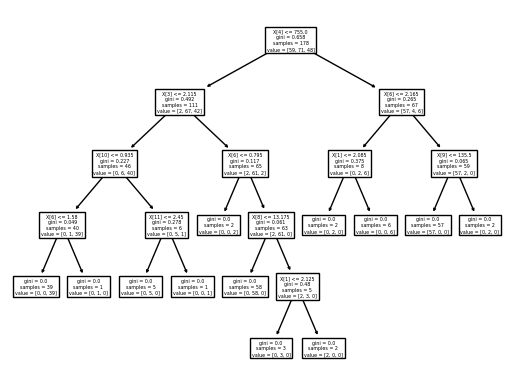

In [3]:
clf = tree.DecisionTreeClassifier()

clf.fit(data[features], data[target])

tree.plot_tree(clf)



3
impurity [0.65831334 0.49216784 0.26464691]
features [ 4 -2 -2]
impurity [0.49216784 0.2268431  0.11739645]
features [ 3 -2 -2]
impurity [0.2268431  0.04875    0.27777778]
features [10 -2 -2]
DecisionTreeClassifier(max_depth=1)
4 755.0 0
DecisionTreeClassifier(max_depth=1)
3 2.1149998903274536 1
DecisionTreeClassifier(max_depth=1)
10 0.9350000023841858 1


NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

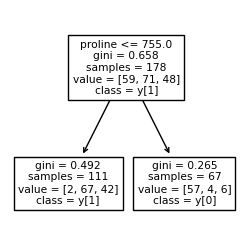

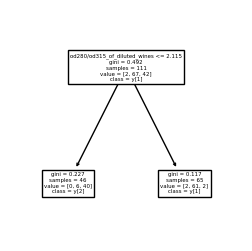

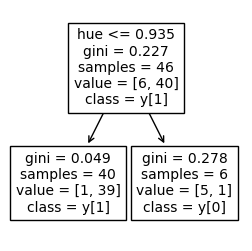

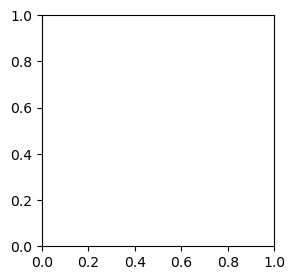

In [46]:

split_idx = 0
left_idx = 1
right_idx = 2

def combine_trees(trees):
    combined = sklearn.base.clone(trees[0])
    for t in trees:
        print(t)
        
        assert_tree_is_single_split(t)
        
        left_is_main = keep_left_side(t)
        
        feature = t.tree_.feature[split_idx]
        threshold = t.tree_.threshold[split_idx]

        # the side that does _not_ continue is classified
        class_idx = right_idx if left_is_main else left_idx    
        value = t.tree_.value[class_idx]
        label = numpy.argmax(value)
        
        print(feature, threshold, label)
        
        #cls = numpy.argmax(value[0])

    return combined
        
def keep_left_side(t):
    keep_left = t.tree_.impurity[left_idx] > t.tree_.impurity[right_idx]
    return keep_left
    
def assert_tree_is_single_split(t):
    # there should be just one split node at index 0, and two leaves (-1 == no children)
    # we expect the left leaf being node 1, and right leaf being node 2        
    assert all(t.tree_.children_left == [left_idx, -1, -1]), t.tree_.children_left
    assert all(t.tree_.children_right == [right_idx, -1, -1]), t.tree_.children_right
        
def fit_tree(base, X, Y):
    """
    
    Note: relies on the internal structure of sklearn DecisionTree
    see https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    """
    
    X_sub = X
    Y_sub = Y

    print(base.max_depth)

    trees = []
    depth = 0
    while True:
        
        # fit a tree of depth=1
        t = sklearn.base.clone(base)
        t.max_depth = 1
        t.fit(X_sub, Y_sub)
        
        # max depth reached
        if len(t.tree_.children_left) == 1:
            break

        # sanity check
        assert_tree_is_single_split(t)

        print('impurity', t.tree_.impurity)
        print('features', t.tree_.feature)

        # Find the subpopulations for next training iteration    
        feature = t.tree_.feature[split_idx]
        threshold = t.tree_.threshold[split_idx]
        col = X_sub.columns[feature]
        if keep_left_side(t):
            keep_mask = X_sub[col] <= threshold
        else:
            keep_mask = X_sub[col] > threshold
        X_sub = X_sub[keep_mask]
        Y_sub = Y_sub[keep_mask]
        
        # debug
        fig, ax = plt.subplots(1, figsize=(3, 3))
        tree.plot_tree(t, ax=ax, feature_names=X.columns, class_names=True)
        
        trees.append(t)
        depth += 1
        
        # Limit depth
        # TODO: support other criteria,
        # such as min_samples_split, min_samples_leaf
        if depth >= base.max_depth:
            break
    
    # combine into a single decision tree
    clf = combine_trees(trees)
    
    fig, ax = plt.subplots(1, figsize=(3, 3))
    tree.plot_tree(clf, ax=ax, feature_names=X.columns, class_names=True)
    
    return clf

        
#children_left = clf.tree_.children_left
#children_right = clf.tree_.children_right
#feature = clf.tree_.feature
#threshold = clf.tree_.threshold
        
    assert len(trees) == depth, (depth, len(trees), base.max_depth)
    
    

clf = tree.DecisionTreeClassifier(max_depth=3)
fit_tree(clf, data[features], data[target])

In [ ]:
def plot_sankey():
    pass
    # https://matplotlib.org/stable/api/sankey_api.html

